In [ ]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [ ]:
GU_D = pd.read_csv('/content/drive/MyDrive/FOREX/trademade_GBP_USD.csv', index_col=0, parse_dates=True, skipinitialspace=True)
GU_D.rename(columns={'date':'Date','open':'Open','high':'High','low':'Low','close':'Close' }, inplace=True)

In [ ]:
GU_D.shape


(2871, 5)

In [ ]:
#!pip install tradermade

In [ ]:
'''
import tradermade as tm
              
# set api key
tm.set_rest_api_key("PgrYfjmkA4RI1AyHJMtV")
  
#get data
#tm.live(currency='EURUSD,GBPUSD',fields=["bid", "mid", "ask"]) # returns live data - fields is optional

# returns historical data for the currency requested interval is daily, hourly, minute - fields is optional

y1 = tm.timeseries(currency='GBPUSD', start="2020-06-15",end="2021-06-15",interval="daily", fields=["open", "high", "low","close"])
y2 = tm.timeseries(currency='GBPUSD', start="2019-06-15",end="2020-06-14",interval="daily", fields=["open", "high", "low","close"])
y3 = tm.timeseries(currency='GBPUSD', start="2018-06-15",end="2019-06-14",interval="daily", fields=["open", "high", "low","close"])
y4 = tm.timeseries(currency='GBPUSD', start="2017-06-15",end="2018-06-14",interval="daily", fields=["open", "high", "low","close"])
y5 = tm.timeseries(currency='GBPUSD', start="2016-06-15",end="2017-06-14",interval="daily", fields=["open", "high", "low","close"])
y6 = tm.timeseries(currency='GBPUSD', start="2015-06-15",end="2016-06-14",interval="daily", fields=["open", "high", "low","close"])
y7 = tm.timeseries(currency='GBPUSD', start="2014-06-15",end="2015-06-14",interval="daily", fields=["open", "high", "low","close"])
y8 = tm.timeseries(currency='GBPUSD', start="2013-06-15",end="2014-06-14",interval="daily", fields=["open", "high", "low","close"])
y9 = tm.timeseries(currency='GBPUSD', start="2012-06-15",end="2013-06-14",interval="daily", fields=["open", "high", "low","close"])
y10 = tm.timeseries(currency='GBPUSD', start="2011-06-15",end="2012-06-14",interval="daily", fields=["open", "high", "low","close"])
y11 = tm.timeseries(currency='GBPUSD', start="2010-06-15",end="2011-06-14",interval="daily", fields=["open", "high", "low","close"])

'''

In [ ]:
#all_data = pd.concat([y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11] )

In [ ]:
#all_data['date'] = pd.to_datetime(all_data['date'])

In [ ]:
#all_data = all_data.sort_values(by='date')

In [ ]:
#all_data.to_csv('trademade_GBP_USD.csv')

In [ ]:
#all_data.isnull().sum()

date     0
open     0
high     0
low      0
close    0
dtype: int64

In [ ]:
GU_D.isna().sum()

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

In [ ]:
GU_D.set_index('Date', inplace=True)

No handles with labels found to put in legend.


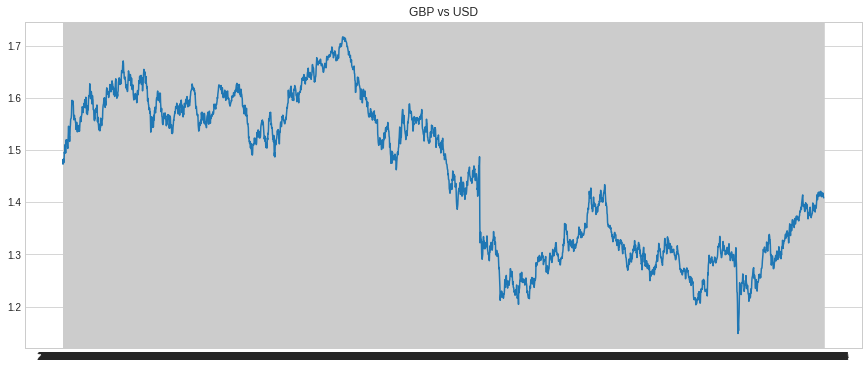

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(GU_D.Close)
plt.title('GBP vs USD')
plt.legend()
plt.show()

In [ ]:
#box plot for Open, High, Low , Close
#GU_D.drop('Volume', axis=1).boxplot()

In [ ]:
'''
#removing outliers above
vol_cut_off = GU_D.Volume.std()*3 + GU_D.Volume.mean()
GU_D.Volume[GU_D.Volume > vol_cut_off] = vol_cut_off
'''

In [ ]:
'''
#removing ouliers below
vol_cut_off =  GU_D.Volume.mean() - GU_D.Volume.std()*3
GU_D.Volume[GU_D.Volume < vol_cut_off] = vol_cut_off
'''

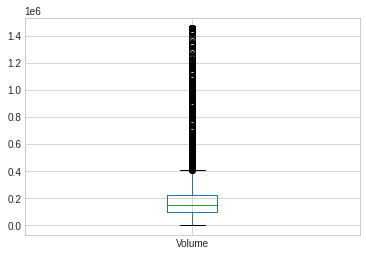

In [ ]:
'''
#boxplot for volume
GU_D[['Volume']].boxplot()
'''

In [ ]:
def get_feats(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "Open", "Close", "High", "Low", "Volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['Open'] = df['Open']
    df_new['Open_1'] = df['Open'].shift(1)
    df_new['Close_1'] = df['Close'].shift(1)
    df_new['High_1'] = df['High'].shift(1)
    #df_new['Low_1'] = df['Low'].shift(1)
    #df_new['Volume_1'] = df['Volume'].shift(1)


    # candle size and direction 
    df_new['Candle_1']  = df_new['Close_1'] - df_new['Open_1']

    # averages of candle
    df_new['Candle_5'] = df_new['Candle_1'].rolling(window=4).mean()
    df_new['Candle_10'] = df_new['Candle_1'].rolling(window=9).mean()
    df_new['Candle_30'] = df_new['Candle_1'].rolling(window=21).mean()
    df_new['Candle_90'] = df_new['Candle_1'].rolling(window=63).mean()
    #df_new['Candle_365'] = df_new['Candle_1'].rolling(window=252).mean()

    

    # average price
    df_new['avg_price_5'] = df['Close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['Close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(window=252).mean().shift(1)
    
    '''
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    '''
    '''

    
   
    
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(window=21).std().shift(1)
    #df_new['std_price_90'] = df['Close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['Close'].rolling(window=252).std().shift(1)
    
    '''
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    '''
    
    # standard deviation of Volumes
    '''
    df_new['std_Volume_5'] = df['Volume'].rolling(window=5).std().shift(1)
    df_new['std_Volume_30'] = df['Volume'].rolling(window=21).std().shift(1)
    df_new['std_Volume_90'] = df['Volume'].rolling(window=63).std().shift(1)
    df_new['std_Volume_365'] = df['Volume'].rolling(window=252).std().shift(1)
    '''
    #standard deviation ratio of Volumes
    '''
    df_new['ratio_std_Volume_5_30'] = df_new['std_Volume_5'] / df_new['std_Volume_30']
    df_new['ratio_std_Volume_5_90'] = df_new['std_Volume_5'] / df_new['std_Volume_90']
    df_new['ratio_std_Volume_5_365'] = df_new['std_Volume_5'] / df_new['std_Volume_365']                                               
    df_new['ratio_std_Volume_30_90'] = df_new['std_Volume_30'] / df_new['std_Volume_90']
    df_new['ratio_std_Volume_30_365'] = df_new['std_Volume_30'] / df_new['std_Volume_365']
    df_new['ratio_std_Volume_90_365'] = df_new['std_Volume_90'] / df_new['std_Volume_365']                                               
     
    '''  

    '''                                            
    # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['Close'] - df['Close'].shift(63)) / df['Close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    '''
    # the target
    df_new['Close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = get_feats(GU_D)

In [ ]:
data.tail()

,Open,Open_1,Close_1,High_1,Low_1,Volume_1,Candle_1,Candle_5,Candle_30,Candle_90,Candle_365,avg_price_5,avg_price_30,avg_price_90,avg_price_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,Close
TimeStamp,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-09,1.4148,1.4176,1.4149,1.4184,1.4121,78061.0000,-0.0027,-0.0004,0.0002,0.0005,0.0005,1.4150,1.4157,1.3969,1.3541,0.0026,0.0033,0.0163,0.0414,0.7924,0.1579,0.0623,0.1993,0.0787,0.3948,1.4111
2021-06-10,1.4111,1.4148,1.4111,1.4189,1.4109,67642.0000,-0.0038,0.0001,0.0000,0.0005,0.0004,1.4151,1.4157,1.3974,1.3544,0.0025,0.0032,0.0163,0.0415,0.7724,0.1507,0.0591,0.1952,0.0765,0.3921,1.4170
2021-06-11,1.4170,1.4111,1.4170,1.4178,1.4073,111385.0000,0.0059,0.0003,0.0001,0.0006,0.0005,1.4154,1.4158,1.3981,1.3548,0.0026,0.0032,0.0162,0.0416,0.8189,0.1603,0.0626,0.1957,0.0764,0.3906,1.4106
2021-06-13,1.4099,1.4170,1.4106,1.4185,1.4095,82766.0000,-0.0064,-0.0012,-0.0004,0.0005,0.0004,1.4142,1.4154,1.3986,1.3552,0.0033,0.0033,0.0160,0.0417,0.9860,0.2031,0.0781,0.2060,0.0793,0.3847,1.4117
2021-06-14,1.4117,1.4099,1.4117,1.4119,1.4099,2958.0000,0.0018,-0.0010,0.0001,0.0005,0.0004,1.4130,1.4155,1.3992,1.3556,0.0028,0.0032,0.0159,0.0417,0.8573,0.1744,0.0665,0.2034,0.0775,0.3813,1.4112


In [ ]:
data.describe()

,Open,Open_1,Close_1,High_1,Low_1,Volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_905_,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_Volume_5,avg_Volume_30,avg_Volume_90,avg_Volume_365,ratio_avg_Volume_5_30,ratio_avg_Volumee_5_90,ratio_avg_Volume_5_365,ratio_avg_Volume_30_90,ratio_avg_Volume_30_365,ratio_avg_Volume_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_Volume_5,std_Volume_30,std_Volume_90,std_Volume_365,ratio_std_Volume_5_30,ratio_std_Volume_5_90,ratio_std_Volume_5_365,ratio_std_Volume_30_90,ratio_std_Volume_30_365,ratio_std_Volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,Close
count,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4.268000e+03,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4.268000e+03,4.268000e+03,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000,4268.000000
mean,1.499234,1.499384,1.499297,1.505178,1.493438,1.760684e+05,1.499595,1.500762,1.503806,1.517794,0.999337,0.997643,0.989844,0.998239,0.990403,0.991911,1.763223e+05,1.779255e+05,181674.463551,196939.904957,1.000327,0.997252,0.966165,0.992799,0.964987,0.965883,0.006973,0.013750,0.023237,0.049168,0.565004,0.338333,0.163813,0.642239,0.322274,0.534840,85890.010285,93097.168247,104373.384328,131421.592774,0.970535,0.925021,0.793087,0.951356,0.823183,0.870903,-0.000071,-0.000348,-0.001488,-0.004459,-0.018608,-0.000070,-0.000070,-0.000074,1.499151
std,0.189964,0.190146,0.189937,0.190632,0.189570,1.708204e+05,0.190143,0.191029,0.193093,0.198108,0.011170,0.022854,0.051212,0.016489,0.048255,0.040428,1.374317e+05,1.275401e+05,120696.445835,135931.355926,0.206930,0.317060,0.446530,0.196436,0.366274,0.270328,0.005044,0.008646,0.014655,0.035024,0.311875,0.221351,0.110631,0.270740,0.182297,0.253765,75611.554808,81359.776648,92437.155711,112490.503150,0.343971,0.403382,0.465739,0.219389,0.362768,0.298607,0.005648,0.012952,0.024648,0.043020,0.084718,0.002597,0.000691,0.000352,0.189765
min,1.149000,1.149000,1.149010,1.167920,1.140950,3.430000e+02,1.158812,1.209330,1.225268,1.256173,0.930546,0.874180,0.776732,0.916105,0.802852,0.832741,3.278940e+04,5.108662e+04,59359.698413,69531.138889,0.152175,0.189465,0.133049,0.246284,0.183908,0.308750,0.000432,0.003174,0.007795,0.017606,0.016592,0.016313,0.008188,0.109795,0.049727,0.123586,0.000000,25162.667554,28178.318393,34045.630030,0.000000,0.000000,0.000000,0.106103,0.121822,0.196627,-0.061777,-0.098073,-0.140775,-0.209376,-0.317010,-0.020163,-0.003639,-0.001467,1.149010
25%,1.319920,1.319920,1.319965,1.325318,1.313480,9.506925e+04,1.318574,1.317833,1.314991,1.326527,0.993367,0.985596,0.964729,0.989604,0.966640,0.971298,1.097936e+05,1.153737e+05,119011.075397,130259.289683,0.894561,0.841044,0.704368,0.910682,0.736260,0.798161,0.003789,0.008347,0.014812,0.032492,0.332419,0.184550,0.088504,0.434189,0.192781,0.355701,48769.277353,54135.746931,56856.987645,67600.215205,0.866506,0.676129,0.439770,0.882666,0.591529,0.695392,-0.002713,-0.007398,-0.014710,-0.029833,-0.059527,-0.001477,-0.000464,-0.000228,1.319965
50%,1.522140,1.522145,1.522085,1.527380,1.516355,1.527825e+05,1.522029,1.525246,1.529266,1.550446,0.999922,1.000661,0.995761,1.000192,0.995550,0.996445,1.407394e+05,1.436032e+05,144616.214286,153922.418651,0.987540,0.984659,0.903751,1.003748,0.927604,0.956604,0.00

In [ ]:
data.info()

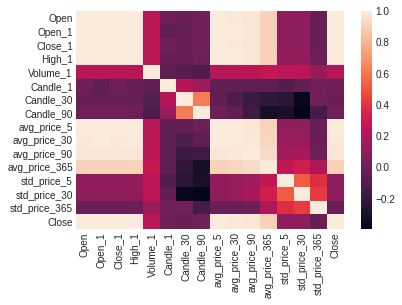

In [ ]:
sns.heatmap(data.corr())

### SEGREGATING TRAIN AND TEST DATA

In [ ]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(2007, 10, 23,0,0)
end_train = datetime.datetime(2021, 3, 14, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()

,Open,Open_1,Close_1,High_1,Volume_1,Candle_1,Candle_30,Candle_90,avg_price_5,avg_price_30,avg_price_90,avg_price_365,std_price_5,std_price_30,std_price_365,Close
count,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000,4189.0000
mean,1.5012,1.5013,1.5012,1.5072,178109.0006,-0.0001,-0.0001,-0.0001,1.5016,1.5028,1.5060,1.5212,0.0070,0.0139,0.0493,1.5011
std,0.1912,0.1914,0.1912,0.1918,171710.2672,0.0084,0.0018,0.0011,0.1914,0.1922,0.1942,0.1984,0.0051,0.0087,0.0353,0.1910
min,1.1490,1.1490,1.1490,1.1679,343.0000,-0.0899,-0.0121,-0.0062,1.1588,1.2093,1.2253,1.2562,0.0004,0.0036,0.0176,1.1490
25%,1.3180,1.3180,1.3184,1.3229,99141.0000,-0.0039,-0.0010,-0.0007,1.3171,1.3165,1.3138,1.3266,0.0038,0.0084,0.0324,1.3184
50%,1.5257,1.5257,1.5257,1.5316,154166.0000,0.0002,0.0000,0.0001,1.5258,1.5282,1.5315,1.5511,0.0059,0.0117,0.0381,1.5256
75%,1.6080,1.6081,1.6079,1.6133,216881.0000,0.0039,0.0010,0.0006,1.6079,1.6080,1.6059,1.6026,0.0088,0.0162,0.0503,1.6079
max,2.1077,2.1077,2.1077,2.1162,1458691.4102,0.0555,0.0070,0.0039,2.0939,2.0726,2.0552,2.0138,0.0696,0.0685,0.2216,2.1077


In [ ]:
data.index

DatetimeIndex(['2007-10-23', '2007-10-24', '2007-10-25', '2007-10-26',
               '2007-10-28', '2007-10-29', '2007-10-30', '2007-10-31',
               '2007-11-01', '2007-11-02',
               ...
               '2021-06-03', '2021-06-04', '2021-06-06', '2021-06-07',
               '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
               '2021-06-13', '2021-06-14'],
              dtype='datetime64[ns]', name='TimeStamp', length=4268, freq=None)

In [ ]:
#segregate data for validation
start_test = datetime.datetime(2021, 3, 15, 0, 0)
end_test = datetime.datetime(2021, 6, 14, 0, 0)
data_test = data.loc[start_test:end_test]
data_test.describe()

,Open,Open_1,Close_1,High_1,Volume_1,Candle_1,Candle_30,Candle_90,avg_price_5,avg_price_30,avg_price_90,avg_price_365,std_price_5,std_price_30,std_price_365,Close
count,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000,79.0000
mean,1.3958,1.3956,1.3958,1.3994,67865.6962,0.0003,0.0003,0.0003,1.3954,1.3930,1.3871,1.3368,0.0045,0.0075,0.0425,1.3961
std,0.0161,0.0160,0.0161,0.0161,33255.6344,0.0053,0.0007,0.0002,0.0153,0.0123,0.0050,0.0118,0.0020,0.0022,0.0026,0.0162
min,1.3688,1.3688,1.3688,1.3714,1457.0000,-0.0142,-0.0013,-0.0002,1.3728,1.3773,1.3779,1.3162,0.0015,0.0032,0.0391,1.3688
25%,1.3824,1.3824,1.3827,1.3847,65684.5000,-0.0027,-0.0003,0.0002,1.3833,1.3835,1.3844,1.3265,0.0031,0.0060,0.0402,1.3827
50%,1.3923,1.3914,1.3923,1.3956,75309.0000,0.0005,0.0004,0.0004,1.3913,1.3895,1.3868,1.3372,0.0038,0.0078,0.0416,1.3923
75%,1.4124,1.4123,1.4124,1.4171,87689.5000,0.0039,0.0008,0.0005,1.4135,1.4017,1.3897,1.3474,0.0058,0.0085,0.0456,1.4124
max,1.4226,1.4226,1.4227,1.4249,127871.0000,0.0174,0.0015,0.0007,1.4189,1.4158,1.3992,1.3556,0.0102,0.0123,0.0469,1.4227


In [ ]:
X_train = data_train.drop(['Close', 'Open'], axis='columns')
y_train = data_train.Close

X_test = data_test.drop(['Close', 'Open'], axis='columns')
y_test = data_test.Close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4189, 14), (79, 14), (4189,), (79,))

### SCALING THE PREDICTOR DATA

In [ ]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [ ]:
import statsmodels.api as sm
y = y_train
x1 = X_train
x = sm.add_constant(x1)

In [ ]:
results = sm.OLS(y,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.032e+07
Date:                Tue, 15 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:24:56   Log-Likelihood:                          14057.
No. Observations:                4189   AIC:                                 -2.809e+04
Df Residuals:                    4176   BIC:                                 -2.801e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Open_1            0.3765      0.024     15.882      0.000       0.330       0.423
Close_1           0.7071      0.022     32.090      0.000       0.664       0.750
High_1           -0.0998      0.037     -2.714      0.007      -0.172      -0.028
Volume_1       2.067e-09   8.64e-10      2.393      0.017    3.74e-10    3.76e-09
Candle_1          0.3307      0.012     27.960      0.000       0.307       0.354
Candle_30         0.4344      0.164      2.650      0.008       0.113       0.756
Candle_90         0.9099      0.308      2.953      0.003       0.306       1.514
avg_price_5      -0.0561      0.026     -2.161      0.031      -0.107      -0.005
avg_price_30      0.0370      0.015      2.402      0.016       0.007       0.067
avg_price_90      0.0356      0.012      2.948      0.003       0.012       0.059
avg_price_365 -9.564e-05      0.003     -0.030      0.976      -0.006       0.006
std_price_5      -0.0605      0.033     -1.823      0.068      -0.126       0.005
std_price_30     -0.0316      0.021     -1.521      0.128      -0.072       0.009
std_price_365     0.0151      0.006      2.743      0.006       0.004       0.026
==============================================================================
Omnibus:                      760.270   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7426.417
Skew:                          -0.573   Prob(JB):                         0.00
Kurtosis:                       9.421   Cond. No.                     2.32e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.77e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### LINEAR REGRESSION (LIN)

In [ ]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.005
MAE: 0.004
R^2: 0.891


In [ ]:
df_pf = pd.DataFrame(predictions_lin, columns=['Prediction'])
df_pf['Target'] = y_test.values
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf['Actual candle in pips'] = (df_pf['Target'] - data_test.Open.values) * 10000
df_pf['Pred candle in pips'] =  (df_pf['Prediction'] - data_test.Open.values) * 10000 

pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_pf.head(20)

,Prediction,Target,Residual,Difference%,Actual candle in pips,Pred candle in pips
0,1.3939,1.3898,-0.0040,0.2914,-31.7000,8.7945
1,1.3906,1.3902,-0.0004,0.0255,3.9000,7.4445
2,1.3912,1.3975,0.0063,0.4484,72.9000,10.2381
3,1.3984,1.3923,-0.0061,0.4381,-52.3000,8.6945
4,1.3929,1.3866,-0.0063,0.4558,-56.6000,6.6058
5,1.3867,1.3833,-0.0034,0.2454,-1.7000,32.2536
6,1.3835,1.3859,0.0023,0.1689,25.3000,1.8980
7,1.3869,1.3731,-0.0138,1.0070,-128.2000,10.0697
8,1.3730,1.3688,-0.0042,0.3058,-42.9000,-1.0480
9,1.3696,1.3746,0.0050,0.3636,57.6000,7.6179


In [ ]:
df_pf['Correct dir'] = 0
for i in range(0,len(df_pf)):
  if df_pf['Actual candle in pips'][i] < 0 and df_pf['Pred candle in pips'][i] < 0 or df_pf['Actual candle in pips'][i] > 0 and df_pf['Pred candle in pips'][i] > 0:
    df_pf['Correct dir'][i] = 1
  else:
    df_pf['Correct dir'][i] = 0

In [ ]:
df_pf.head()

,Prediction,Target,Residual,Actual candle in pips,Pred candle in pips,Difference%,Correct dir
0,1.3935,1.3898,-0.0037,-31.7000,5.6415,0.2687,0
1,1.3901,1.3902,0.0001,3.9000,2.7546,0.0082,1
2,1.3910,1.3975,0.0065,72.9000,7.6815,0.4667,1
3,1.3983,1.3923,-0.0061,-52.3000,8.4021,0.4360,0
4,1.3927,1.3866,-0.0061,-56.6000,4.4018,0.4399,0


In [ ]:
len(df_pf)

79

In [ ]:
df_pf['Correct dir'].sum() / len(df_pf)

0.43037974683544306

In [ ]:
X_test_7_days = X_scaled_test[-7:]

In [ ]:
X_test_7_days

array([[-0.44354412, -0.44891207, -0.44394127, -0.46971309, -0.42254046,
        -1.01965306, -0.45207778, -0.45789157, -0.56814556, -0.84681613,
         0.08010415,  0.71304372,  1.11187688,  0.93813941,  1.16379656,
         1.0002313 , -0.71076631, -0.85806729, -0.96602102, -0.26658367,
         0.68903568,  0.63466949, -1.07639735,  0.28466061, -1.49174598,
        -2.13758058, -0.8939181 , -1.11389229, -0.48325047, -0.22982604,
         0.09050595, -0.83696939, -0.94010416, -1.41882959, -1.22006909,
        -0.56241786, -0.54778114, -0.70966621, -0.78597115,  0.23018928,
         0.81084942,  1.13646601, -1.1138867 ,  0.71064687, -1.69476675,
        -2.34014217,  0.12049785, -0.30941195,  0.35649382,  0.91225974,
         1.23443812, -0.30676124,  0.89826804,  1.17095457],
       [-0.43747637, -0.44394748, -0.43797727, -0.45933913, -0.4416187 ,
        -0.55931696, -0.44998735, -0.45468085, -0.56463764, -0.84467413,
         0.06645975,  0.70399396,  1.11123702,  0.93496949,  1.

In [ ]:
seven_day_close = lin.predict(X_test_7_days)

In [ ]:
seven_day_close

array([1.4160058 , 1.41764713, 1.41477012, 1.41094567, 1.41760399,
       1.41009663, 1.41174372])

In [ ]:
seven_day_close = lin.predict(X_test_7_days)

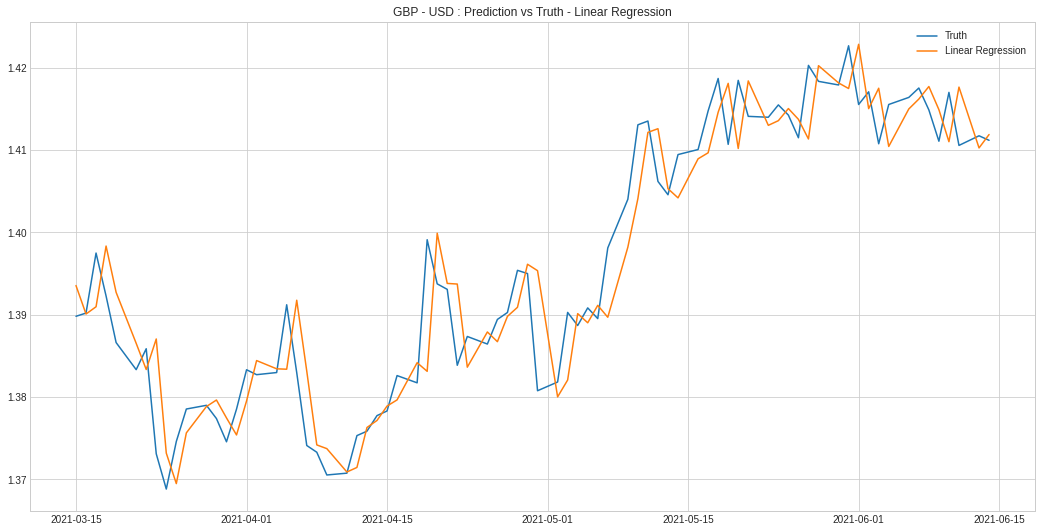

In [ ]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('GBP - USD : Prediction vs Truth - Linear Regression')
plt.show()

### SGD REGRESSOR (SGD)

In [ ]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 0.0001, 'eta0': 0.03, 'penalty': 'l2'}
RMSE: 0.006
MAE: 0.005
R^2: 0.868


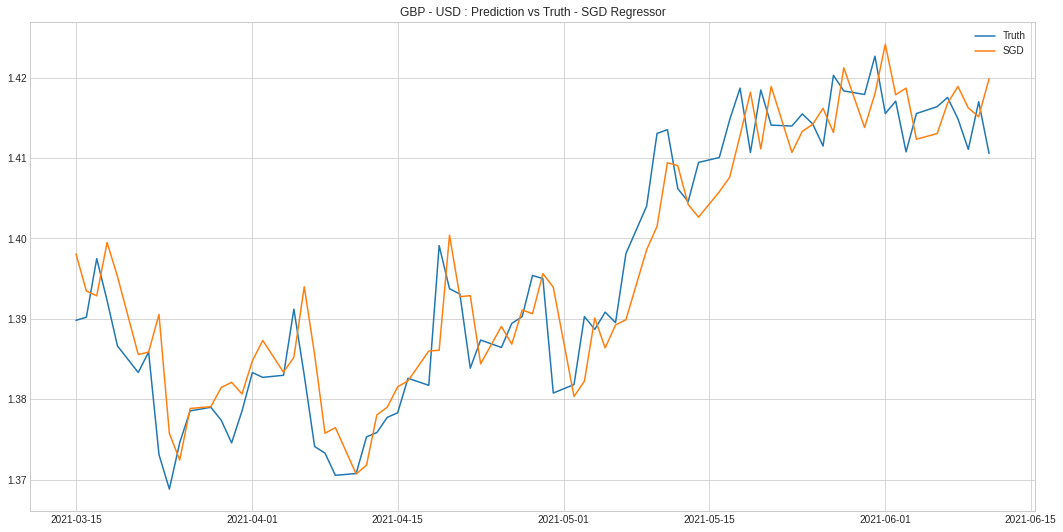

In [ ]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('GBP - USD : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

### Extreme Gradient Boosting Regressor (XGB)

In [ ]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  4.3min finished


[12:04:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.7}
[12:04:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.006
MAE: 0.005
R^2: 0.844


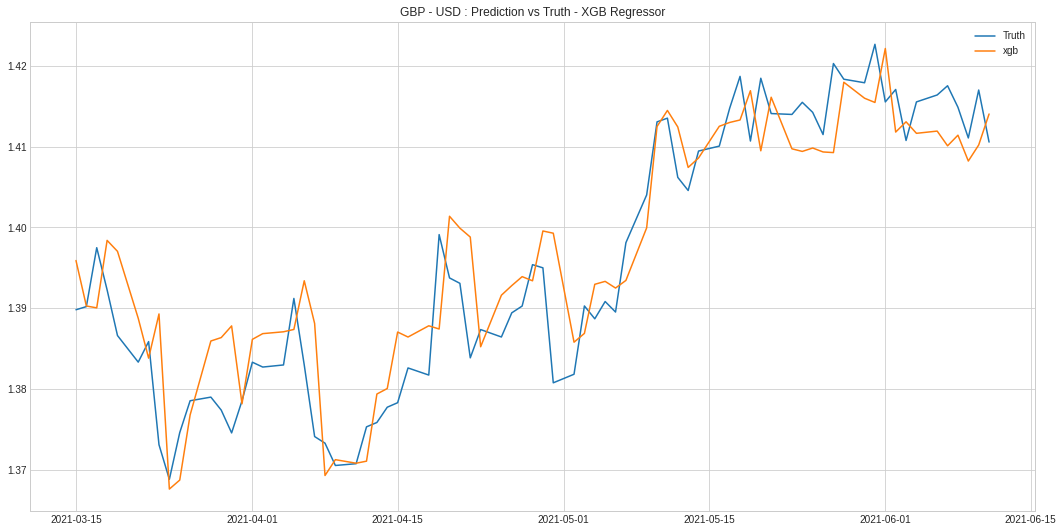

In [ ]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('GBP - USD : Prediction vs Truth - XGB Regressor')
plt.show()

### Bagging Regressor (BGR)

In [ ]:
BaggingRegressor?

In [ ]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.005
MAE: 0.004
R^2: 0.889


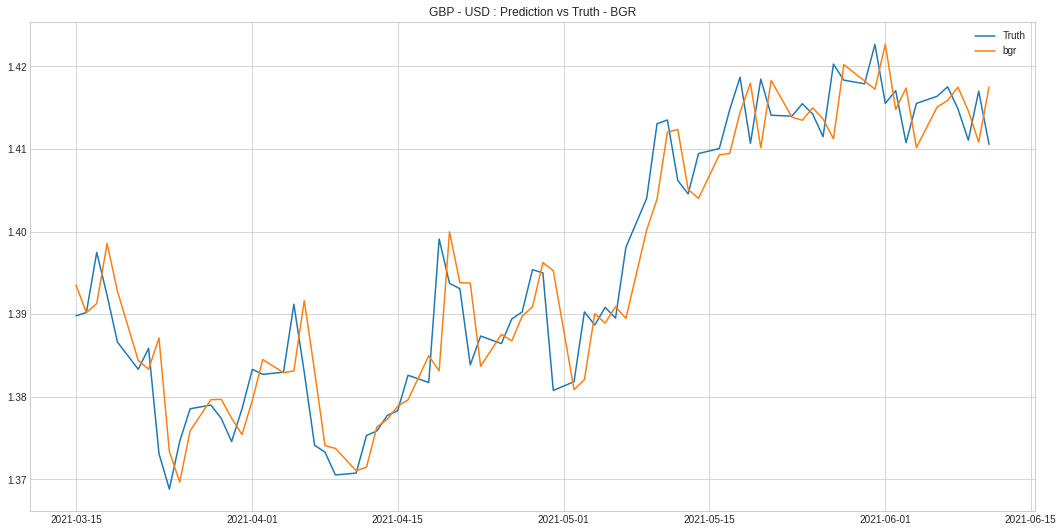

In [ ]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('GBP - USD : Prediction vs Truth - BGR')
plt.show()

### Random Forest Regressor (RF)

In [ ]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))


{'max_depth': 50, 'min_samples_split': 20}
RMSE: 0.006
MAE: 0.004
R^2: 0.880


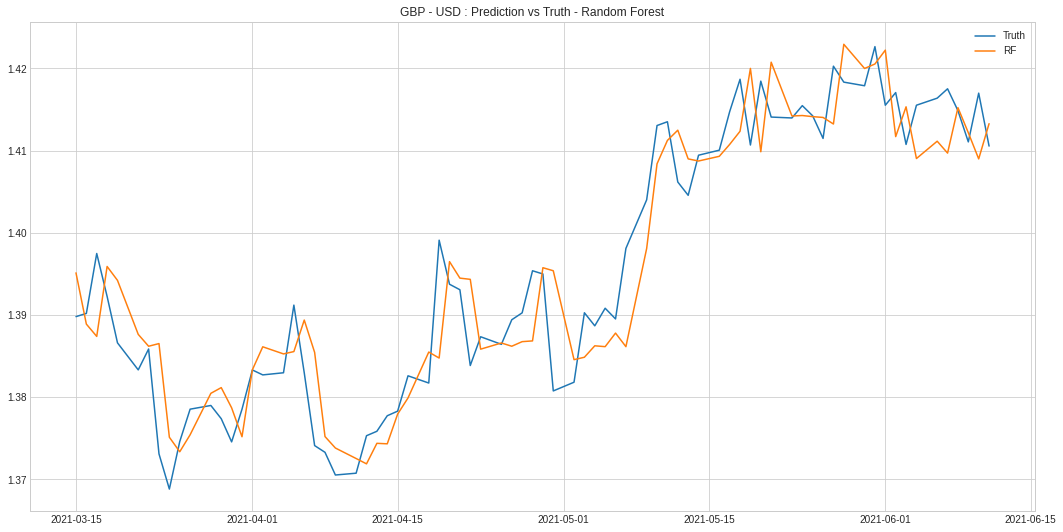

In [ ]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('GBP - USD : Prediction vs Truth - Random Forest')
plt.show()

The model with the least mean_absolute_error:
 LIN    0.004068
dtype: float64


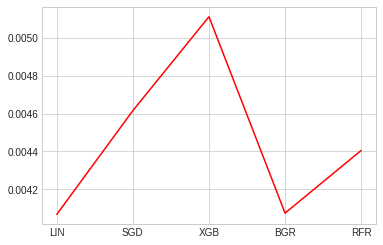

In [ ]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                #'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')

### Saving, Loading and Predicting with the BGR Model

In [ ]:
#saving the BGR model with sklearn:joblib
joblib.dump(bgr, 'bgr_eurusd_10062019.pkl')

['bgr_eurusd_10062019.pkl']

In [ ]:
#loading the saved model
model = joblib.load('bgr_eurusd_10062019.pkl')

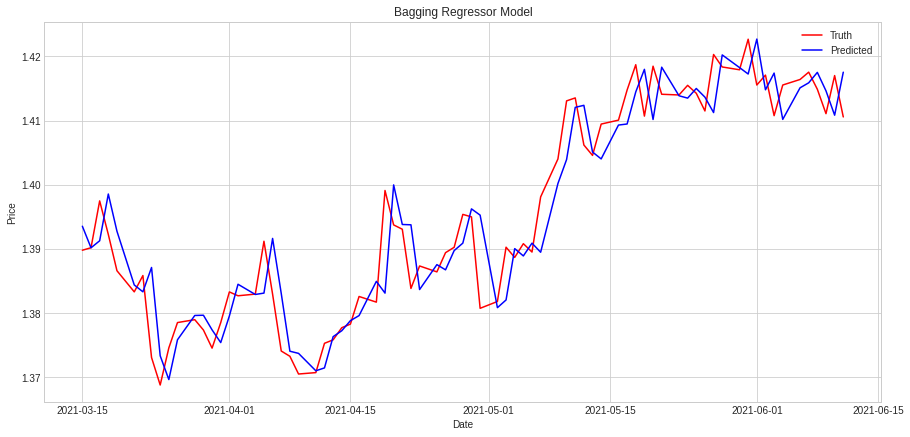

In [ ]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

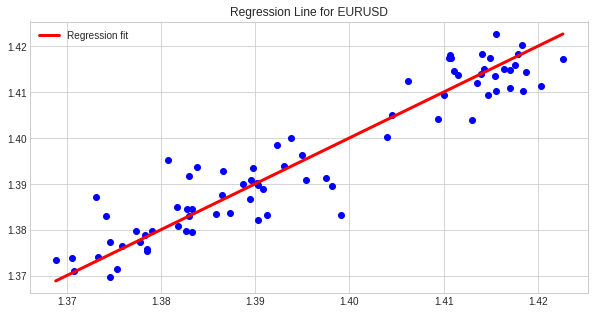

In [ ]:
#plotting regression line
plt.style.use('seaborn-whitegrid')
plt.scatter(y_test, pred,color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3, label='Regression fit')
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title("Regression Line for EURUSD")
plt.legend()
plt.show()